# Article Review & Reproduction

This notebook is a work due for Pr. Nelly Pustelnik's machine learning class of the M2 complex systems at ENS de Lyon. In the following we review an article introducing physics-informed neural networks and reproduce some of its results.

**Students**: Ayoub Dhibi & Théodore Farmachidi

**Article**:
[Maziar Raissi, , Paris Perdikaris, George Em Karniadakis. "Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations." (2017).](https://arxiv.org/abs/1711.10561)

**Note**: the presentation is expected to include a general introduction, the article's specific features in relation to the state of the art, a more technical section on the article's contributions, and a presentation of the results reproduced.

---

## Table of Contents
1. [Article Summary](#article-summary)
2. [Key Concepts & Methods](#key-concepts--methods)
3. [Important Figures & Results](#important-figures--results)
4. [Reproduction of Results](#reproduction-of-results)
5. [Personal Notes & Questions](#personal-notes--questions)

---

**Roadmap**:

1. Analyze the article and its details
2. Reproduce two examples (one per part)
3. Apply the method to a new use case
4. Prepare the presentation (10' presentation + 10' questions)

**Due dates**: 
- ML challenge for the 04/01
- notebook for the 05/01
- presentation for the 09/01

## 1. Article Summary <a id="article-summary"></a>



### 2. Continuous Time Models


## 2. Key Concepts & Methods <a id="key-concepts--methods"></a>

_List and explain the main concepts, equations, and methods introduced in the article. Use bullet points, equations, or diagrams as needed._

## 4. Reproduction of Results <a id="reproduction-of-results"></a>



Let's reproduce the burger equation solver.

In [33]:
import numpy as np
import torch
import torch.nn as nn
import math
import scipy

Function definition

In [30]:
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        # forme du reseau de neurone
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = torch.tanh

    def forward(self, t, x):
        X = torch.cat([t, x], dim=1)
        for layer in self.layers[:-1]:
            X = self.activation(layer(X))
        return self.layers[-1](X)

def f(x, t, model):
    u = model(t, x)
    u_t = torch.autograd.grad(u, t,grad_outputs=torch.ones_like(u),create_graph=True,  retain_graph = True)[0]
    u_x = torch.autograd.grad(u, x,grad_outputs=torch.ones_like(u),create_graph=True,  retain_graph = True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),create_graph=True,  retain_graph = True)[0]
    f = u_t + u * u_x - (0.01 / math.pi) * u_xx
    return f

Data loading

In [56]:
data = scipy.io.loadmat('data/burgers_shock.mat')
t = data['t'].flatten()[:, None]         # (Nt,1)
x = data['x'].flatten()[:, None]         # (Nx,1)
u_exact = np.real(data['usol']).T        # shape (Nt, Nx)


Grid creation

In [59]:
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  # (Nt*Nx,2)
u_star = u_exact.flatten()[:,None]
X_star_tensor = torch.tensor(X_star, dtype=torch.float32, requires_grad=True)
u_star_tensor = torch.tensor(u_star, dtype=torch.float32)

We then get the collocation points (randomly chosen, but latin hypercube sampling in the article)

In [61]:
import numpy as np
import torch

N_f = 10000
lb = np.array([x.min(), t.min()])
ub = np.array([x.max(), t.max()])

# tirage uniforme simple
x_f = lb[0] + (ub[0]-lb[0]) * np.random.rand(N_f, 1)
t_f = lb[1] + (ub[1]-lb[1]) * np.random.rand(N_f, 1)

X_f = np.hstack([x_f, t_f])
X_f_tensor = torch.tensor(X_f, dtype=torch.float32, requires_grad=True)

Condition initiale

In [63]:
X_u = np.hstack((x, t[0]*np.ones_like(x)))
u_u = u_exact[0,:][:,None]
X_u_tensor = torch.tensor(X_u, dtype=torch.float32, requires_grad=True)
u_u_tensor = torch.tensor(u_u, dtype=torch.float32)

In [65]:
layers = [2,50,50,50,1]
model = PINN(layers)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------
# Entraînement
# -----------------------
for epoch in range(5000):
    optimizer.zero_grad()
    
    # IC loss
    u_pred = model(X_u_tensor[:,1:2], X_u_tensor[:,0:1])
    loss_ic = torch.mean((u_pred - u_u_tensor)**2)
    
    # PDE loss
    f_pred = f(X_f_tensor[:,0:1], X_f_tensor[:,1:2], model)
    loss_pde = torch.mean(f_pred**2)
    
    # Loss totale
    loss = loss_ic + loss_pde
    
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.3e}")


Epoch 0, Loss = 5.435e-01
Epoch 500, Loss = 8.811e-02
Epoch 1000, Loss = 6.932e-02
Epoch 1500, Loss = 3.364e-02
Epoch 2000, Loss = 1.614e-02
Epoch 2500, Loss = 9.863e-03
Epoch 3000, Loss = 7.011e-03
Epoch 3500, Loss = 5.981e-03
Epoch 4000, Loss = 4.042e-03
Epoch 4500, Loss = 3.306e-03


In [ ]:
u_pred_grid = model(X_star_tensor[:,1:2], X_star_tensor[:,0:1]).detach().numpy()

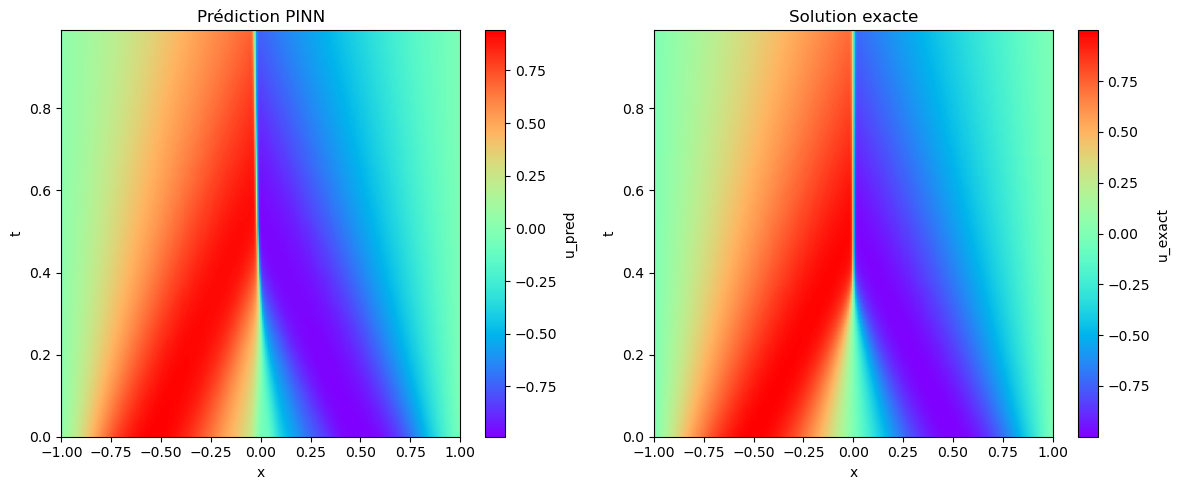

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# À gauche : prédiction
plt.subplot(1,2,1)
plt.imshow(U_pred_grid, extent=[x.min(), x.max(), t.min(), t.max()],
           origin='lower', aspect='auto', cmap='rainbow')
plt.colorbar(label='u_pred')
plt.title('Prédiction PINN')
plt.xlabel('x')
plt.ylabel('t')

# À droite : solution exacte
plt.subplot(1,2,2)
plt.imshow(U_exact_grid, extent=[x.min(), x.max(), t.min(), t.max()],
           origin='lower', aspect='auto', cmap='rainbow')
plt.colorbar(label='u_exact')
plt.title('Solution exacte')
plt.xlabel('x')
plt.ylabel('t')

plt.tight_layout()
plt.show()